## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2021-11-01 18:30:24--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2021-11-01 18:30:24--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc24b95d3fa31791ca8fd8704905.dl.dropboxusercontent.com/cd/0/inline/BZJGoIR4cGq91-pFJISpMrvJTzRmoah6IQHpX4JsKYwHRvts6hc78SO3xQuRpMhUv_9chcdelMYhzbRQT4180QUa0qsgFYOFSWnQvulutV2nzCbWe0TPRjACq6MbaJOBrq1GEr4pAOVwViOwdJbw5zki/file# [following]
--2021-11-01 18:30:24--  https://uc24b95d3fa31791ca8fd8704905.dl.dropboxusercontent.com/cd/0/inline/BZJGoIR4cGq91-pFJISpMrvJTzRmoah6IQHpX4JsKYwHRvts6hc78SO3xQuRpMhUv_9chcdelMYhzbRQT4180QUa0qsgFYOFSWnQvu

In [2]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

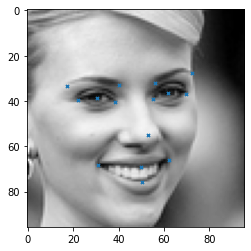

In [4]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [5]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
brightness_augmentation = True
sample_image_index = 20  

def alter_brightness(X, y):
    altered_brightness_images = []
    inc_brightness_images = np.clip(X*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(X*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((y, y))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(x_train, y_train)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    x_train = np.concatenate((x_train, altered_brightness_train_images))
    y_train = np.concatenate((y_train, altered_brightness_train_keypoints))



Shape of altered_brightness_train_images: (2996, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (2996, 30)


In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="elu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(64, kernel_size=(2, 2), activation="elu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        layers.Conv2D(128, kernel_size=(2, 2), activation="elu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
     
        layers.Flatten(),
        layers.Dense(500, activation="elu"),
        layers.Dropout(0.5),
     
        layers.Dense(500, activation="elu"),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       3

In [8]:
batch_size = 128
epochs = 1000

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

model.compile(loss=root_mean_squared_error, optimizer="adam")



model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback],validation_split=0.1)

Epoch 1/1000
32/32 [==============================] - 34s 105ms/step - loss: 0.3425 - val_loss: 0.2661
Epoch 2/1000
32/32 [==============================] - 3s 80ms/step - loss: 0.0926 - val_loss: 0.0879
Epoch 3/1000
32/32 [==============================] - 3s 82ms/step - loss: 0.0682 - val_loss: 0.0722
Epoch 4/1000
32/32 [==============================] - 3s 80ms/step - loss: 0.0621 - val_loss: 0.0510
Epoch 5/1000
32/32 [==============================] - 3s 83ms/step - loss: 0.0597 - val_loss: 0.0452
Epoch 6/1000
32/32 [==============================] - 3s 82ms/step - loss: 0.0546 - val_loss: 0.0449
Epoch 7/1000
32/32 [==============================] - 3s 80ms/step - loss: 0.0507 - val_loss: 0.0442
Epoch 8/1000
32/32 [==============================] - 3s 82ms/step - loss: 0.0475 - val_loss: 0.0438
Epoch 9/1000
32/32 [==============================] - 3s 80ms/step - loss: 0.0455 - val_loss: 0.0431
Epoch 10/1000
32/32 [==============================] - 3s 83ms/step - loss: 0.0427 - val_

In [9]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.3544053


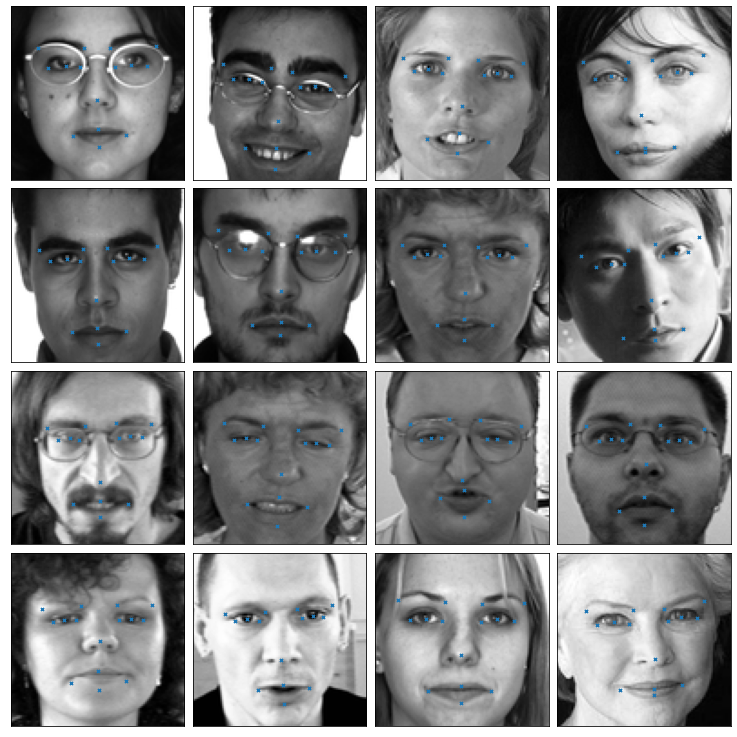

In [10]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

# Reporting.

## What is the best result you got when testing?  

**Answer**: The mean pixel error is 1.3544053.

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: I started with the recommended trick, which is data augmentation. I doubled the number of paintings I trained through performing brightness alteration. This procedure made it easy to reduce overfitting when training model. In this way, I had 2,996 images.  
Then I dealt with an extended model in which I used the "elu" activation function. After many attempts to select the appropriate function, this one gave me the best result. First, I created a convolutional layer with 32 nodes and a kernel size (3.3). Then I used Max Pooling (with pool_size=(2, 2)) to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. Then I used another trick. I used regularization techniques such as Dropout. Next I add second Convolutional layers with 64 nodes, Max Pooling layer and Dropout. After each Max Pooling I added a Dropout. I applied the principle of increasing the value in each Dropout. So in my model you'll see three Convolutional layers which nodes (32,64,128), then Max Pooling and Dropout after each. After that, I applies flatten and add two hidden layers. Both have 500 nodes. Additionally, after the first one, I used Dropout.
Then, on the basis of the proposed model, using Adam's optimizer and setting the number epochs = 1000 (but I used early stopping o avoid overtraining, so less than 1000 epochs), I am able to obtain the mean pixel error between 1.3 and 1.4


